In [18]:
import pandas as pd
import optuna
import lightgbm
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

from imblearn.over_sampling import SMOTE
from sklearn.svm import SVC
from sklearn.metrics import log_loss, classification_report,precision_recall_curve, auc, ConfusionMatrixDisplay, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import resample


SEED = 123

In [21]:
# read opportunity data
opp_df = pd.read_csv('src/opp_data_updated.csv')
opp_df['CreatedDate'] = pd.to_datetime(pd.to_datetime(opp_df['CreatedDate']).dt.date)
opp_df['opp_estimated_close_date'] = pd.to_datetime(opp_df['opp_estimated_close_date'])
opp_df.head()

,OpportunityId,opp_estimated_close_date,IsWon,CreatedDate
0,0061300001AC115AAD,2019-05-28,False,2014-09-23
1,0061300001AC115AAD,2019-05-28,False,2014-09-24
2,0061300001AC115AAD,2019-05-28,False,2014-10-02
3,0061300001AC115AAD,2019-05-28,False,2014-10-21
4,0061300001AC115AAD,2019-05-28,False,2014-10-24


In [22]:
# sort the table by created date and keep the first created date for each opportunity - it represents when the opportunity was created
opp_df = opp_df.sort_values('CreatedDate', ascending=True).drop_duplicates(subset=['OpportunityId'], keep='first')

start_date = opp_df.CreatedDate.min()
end_date = opp_df.opp_estimated_close_date.max()

total_datapoints = pd.DataFrame()

# iterate through each day of the total cycle and add stages for opportunities open on a certain date
for cur_date in tqdm(pd.date_range(start_date, end_date, freq='D', inclusive='both')):
    known = opp_df[(opp_df.CreatedDate < cur_date) & (cur_date <= opp_df.opp_estimated_close_date)]
    datapoints = known[['OpportunityId', 'opp_estimated_close_date', 'IsWon']].copy()
    datapoints['CreatedDate'] = cur_date
    total_datapoints = pd.concat([total_datapoints, datapoints], ignore_index=True)

opp_df = total_datapoints
opp_df.head()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4978/4978 [00:23<00:00, 208.85it/s]


,OpportunityId,opp_estimated_close_date,IsWon,CreatedDate
0,0063000000YvrLnAAJ,2022-11-30,False,2010-01-23
1,0063000000YvrLnAAJ,2022-11-30,False,2010-01-24
2,0063000000YvrLnAAJ,2022-11-30,False,2010-01-25
3,0063000000YvrLnAAJ,2022-11-30,False,2010-01-26
4,0063000000YvrLnAAJ,2022-11-30,False,2010-01-27


In [23]:
# read incoming communications (aggregated) data
fc_df = pd.read_parquet('src/output_data_fc.parquet')
fc_df.head()

,activity_ts,crm_id,owner_included,duration_in,n_recipients
0,2021-10-12 02:52:51,0064v00001q6cOgAAI,0,132,1
1,2021-10-12 02:53:04,0064v00001q6cOgAAI,0,132,1
2,2021-10-12 08:04:18,0064v00001tjSm3AAE,0,24,1
3,2021-10-12 08:14:43,0064v00001tjSm3AAE,0,1,1
4,2021-10-12 08:15:43,0064v00001tjSm3AAE,0,11,1


In [24]:
min_date = pd.to_datetime(fc_df.activity_ts.dt.date.min())
opp_df = opp_df[opp_df.CreatedDate >= min_date]
opp_df = opp_df[opp_df.opp_estimated_close_date >= min_date].reset_index(drop=True)
opp_df.head()

,OpportunityId,opp_estimated_close_date,IsWon,CreatedDate
0,0063000000YvrLnAAJ,2022-11-30,False,2021-10-12
1,0061300001ADuHtAAL,2022-08-29,False,2021-10-12
2,0061300001B0qRQAAZ,2022-07-29,False,2021-10-12
3,0061300001IbZXCAA3,2023-02-28,False,2021-10-12
4,0061300001KvHGxAAN,2022-11-08,False,2021-10-12


In [25]:
labels = ['fc', 'tc', 'fo', 'me']

In [26]:
for label in labels:
    comm_df = pd.read_parquet(f'src/output_data_{label}.parquet')
    comm_df['CreatedDate'] = pd.to_datetime(comm_df['activity_ts'].dt.date)
    comm_df = comm_df.groupby(['CreatedDate', 'crm_id'], as_index=False).agg(
        crm_id=('crm_id', 'first'),
        n=('crm_id', 'count'),
        owner_included=('owner_included', 'sum'),
        duration_in=('duration_in', 'sum'),
        n_recipients=('n_recipients', 'sum'),
    )
    comm_df = comm_df.rename(columns={c: c + f"__{label}" for c in comm_df.columns if c not in ['CreatedDate', 'crm_id']})
    comm_df = comm_df.rename(columns={'crm_id': "OpportunityId"})
    opp_df = opp_df.merge(comm_df, how='left', on=['OpportunityId', 'CreatedDate'])
    
opp_df = opp_df.fillna(0)


In [36]:
window_sizes = [7, 30, 90]
columns = ['n__fc', 'n__tc', 'n__fo', 'n__me', 'duration_in__fc', 'duration_in__tc', 'duration_in__fo', 'duration_in__me']

for window in window_sizes:
    groupbyrolling = opp_df.groupby('OpportunityId', as_index=False)[columns].rolling(window=window, closed='left', min_periods=0)
    for col in columns:
        if col.startswith('n__'):
            opp_df[f"{col}__rw{window}"] = groupbyrolling.sum()[col]
        elif col.startswith('duration_in__'):
            opp_df[f"{col}__rw{window}"] = groupbyrolling.sum()[col]
            label = col[-2:]
            opp_df[f"mean_{col}__rw{window}"] = opp_df[f"{col}__rw{window}"] / (opp_df[f"n__{label}__rw{window}"] + 1e-8)
        

groupbyexpanding = opp_df.groupby('OpportunityId', as_index=False)[columns].expanding(1)
for col in columns:
    if col.startswith('n__'):
        opp_df[f"{col}__x"] = groupbyexpanding.sum()[col].droplevel(0)
    elif col.startswith('duration_in__'):
        opp_df[f"{col}__x"] = groupbyexpanding.sum()[col].droplevel(0)
        label = col[-2:]
        opp_df[f"mean_{col}__x"] = opp_df[f"{col}__x"] / (opp_df[f"n__{label}__x"] + 1e-8)


opp_df

,OpportunityId,opp_estimated_close_date,IsWon,CreatedDate,n__fc,owner_included__fc,duration_in__fc,n_recipients__fc,n__tc,owner_included__tc,...,mean_duration_in__me__rw7,n__me__rw30,duration_in__me__rw30,mean_duration_in__me__rw30,n__me__rw90,duration_in__me__rw90,mean_duration_in__me__rw90,n__me__x,duration_in__me__x,mean_duration_in__me__x
0,0063000000YvrLnAAJ,2022-11-30,False,2021-10-12,0.0,0.0,0.0,0.0,3.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000
1,0061300001ADuHtAAL,2022-08-29,False,2021-10-12,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000
2,0061300001B0qRQAAZ,2022-07-29,False,2021-10-12,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000
3,0061300001IbZXCAA3,2023-02-28,False,2021-10-12,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000
4,0061300001KvHGxAAN,2022-11-08,False,2021-10-12,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
160306,0064v000024apA4AAI,2023-09-08,False,2023-09-07,0.0,0.0,0.0,0.0,1.0,12.0,...,0.0,0.0,0.0,0.000000,1.0,1800.0,1799.999982,1.0,1800.0,1799.999982
160307,0064v000024b4LzAAI,2023-09-07,False,2023-09-07,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000
160308,0064v000027K116AAC,2023-09-08,False,2023-09-07,1.0,1.0,33.0,1.0,1.0,1.0,...,0.0,2.0,3600.0,1799.999991,3.0,7200.0,2399.999992,3.0,7200.0,2399.999992
160309,0064v000024apA4AAI,2023-09-08,False,2023-09-08,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,1.0,1800.0,1799.999982,1.0,1800.0,1799.999982


In [37]:
print(len(opp_df[opp_df.n__fc__x < opp_df.n__fc__rw90]))
print(len(opp_df[opp_df.n__tc__x < opp_df.n__tc__rw90]))
print(len(opp_df[opp_df.n__fo__x < opp_df.n__fo__rw90]))

0
0
0


<Axes: xlabel='CreatedDate'>

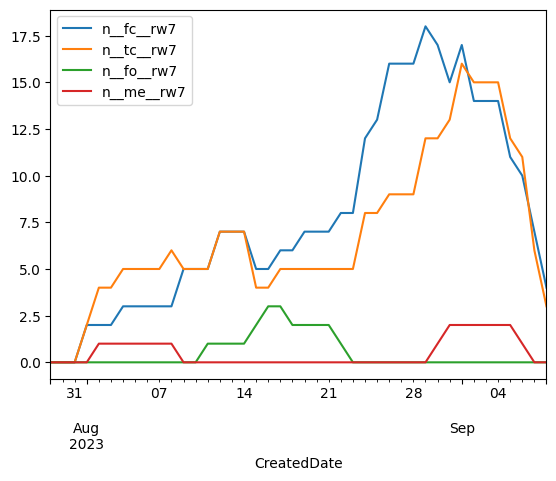

In [38]:
opp_df[opp_df.OpportunityId == '0064v000027K116AAC'].plot(x='CreatedDate', y=['n__fc__rw7', 'n__tc__rw7', 'n__fo__rw7', 'n__me__rw7'])

In [40]:
# find the first time opportunity is created
opp_df['first_created_date'] = opp_df.groupby('OpportunityId')['CreatedDate'].transform('min')

# find fiscal quarters for the datetime features
opp_df.loc[:, 'CreatedDate__fq'] = pd.PeriodIndex(opp_df['CreatedDate'], freq='Q-JUN')
opp_df.loc[:, 'opp_estimated_close_date__fq'] = pd.PeriodIndex(opp_df['opp_estimated_close_date'], freq='Q-JUN')

opp_df[['opp_estimated_close_date', 'opp_estimated_close_date__fq', 'CreatedDate', 'CreatedDate__fq']]

opp_df['target'] = (opp_df['IsWon']) & (opp_df['opp_estimated_close_date__fq'] == opp_df['CreatedDate__fq'])
opp_df['target'].value_counts()

opp_df.to_csv('dataset_rw.csv')

In [83]:
opp_df.describe().loc['count'].describe()

count         66
unique         1
top       183855
freq          66
Name: count, dtype: int64